Group Presentation 4 – Capstone Project

Conestoga College – Applied AI & ML

Group Name: Group 2

Project Title: Soil Health Prediction for Sustainable Agriculture

GitHub Repo: https://github.com/Albrightmaduka9053136/DimensionalityReduction_Workshop.git

Video Presentation Link (Clipchamp):
  
Team Members:

Abdullahi Abdirizak Mohamed – 9082466. 

Albright Maduka Ifechukwude – 9053136. 

Aiswarya Thekkuveettil Thazhath – 8993970.


**Use-Case (100 words).**  
We predict the most suitable crop (label) from agronomic features: N, P, K, pH, temperature, humidity, and rainfall, extended with additional field factors from a second dataset. Since the previous checkpoint, we integrated a new source, harmonized schemas, and refactored the workflow to follow the professor’s workshop pipeline: Missing-Values Ratio → Low-Variance → High-Correlation → Box-Cox/Tukey transforms → PCA → Random Forest (bootstrapped) importance → Forward/Backward feature selection. We classify crop types using a compact, high-signal feature set and report accuracy/F1. The revised hypothesis tests whether NPK, pH, temperature, humidity, and rainfall significantly affect crop classification after dimensionality reduction and selection.

**Revised Hypotheses**

- **H₀ (Null):** After dimensionality reduction, features *(N, P, K, pH, temperature, humidity, rainfall)* do **not** have a statistically significant effect on crop classification performance.
- **H₁ (Alternative):** After dimensionality reduction, features *(N, P, K, pH, temperature, humidity, rainfall)* **do** significantly affect crop classification performance.

*Operationalization:* We compare model performance (accuracy/F1) using features retained by filters/wrappers versus baselines. Rejecting H₀ implies these features retain predictive signal post-reduction.


Imports & Paths

In [74]:
# Professor-style workshop: explicit steps per rubric
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, RFE, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

plt.rcParams["figure.figsize"] = (6.5, 3.5)
plt.rcParams["axes.grid"] = True

# ---- Update these if your filenames differ ----
PATH_A = "./Data/Crop_recommendation 2.csv"     # 8 columns
PATH_B = "./Data/Crop_recommendationV2 1.csv"    # 23 columns
TARGET = "label"
RANDOM_STATE = 42

Load, Harmonize, Combine

In [75]:
# Load both sources
a = pd.read_csv(PATH_A)
b = pd.read_csv(PATH_B)

# Ensure consistent column naming (already aligned in your files)
# (Both have: N, P, K, temperature, humidity, ph, rainfall, label)
# The V2 file has many extra columns; we keep union of columns.
cols_union = sorted(set(a.columns) | set(b.columns))
a_u = a.reindex(columns=cols_union)
b_u = b.reindex(columns=cols_union)

# Combine rows (stack); missing extra columns in A become NaN -> handled downstream
data = pd.concat([a_u, b_u], ignore_index=True)

# Split X/y for numeric DR
y = data[TARGET].copy()
X = data.drop(columns=[TARGET]).select_dtypes(include=[np.number]).copy()

print("Combined:", data.shape, "| X numeric:", X.shape, "| y:", y.shape)
display(data.head())


Combined: (4400, 23) | X numeric: (4400, 22) | y: (4400,)


,K,N,P,co2_concentration,crop_density,fertilizer_usage,frost_risk,growth_stage,humidity,irrigation_frequency,...,ph,rainfall,soil_moisture,soil_type,sunlight_exposure,temperature,urban_area_proximity,water_source_type,water_usage_efficiency,wind_speed
0,43,90,42,NaN,NaN,NaN,NaN,NaN,82.002744,NaN,...,4.000220,202.935536,NaN,NaN,NaN,20.879744,NaN,NaN,NaN,NaN
1,41,85,58,NaN,NaN,NaN,NaN,NaN,80.319644,NaN,...,7.038096,226.655537,NaN,NaN,NaN,21.770462,NaN,NaN,NaN,NaN
2,44,60,55,NaN,NaN,NaN,NaN,NaN,82.320763,NaN,...,7.840207,263.964248,NaN,NaN,NaN,23.004459,NaN,NaN,NaN,NaN
3,40,74,35,NaN,NaN,NaN,NaN,NaN,80.158363,NaN,...,6.980401,242.864034,NaN,NaN,NaN,26.491096,NaN,NaN,NaN,NaN
4,42,78,42,NaN,NaN,NaN,NaN,NaN,81.604873,NaN,...,7.628473,262.717340,NaN,NaN,NaN,20.130175,NaN,NaN,NaN,NaN


**Dimensionality Reduction Plan (Professor’s Agenda)**  
1) Missing Values Ratio → drop high-missing columns; impute remaining.  
2) Low Variance Filter → remove near-constant features.  
3) High Correlation Filter → reduce redundancy (multicollinearity).  
4) Box-Cox (strictly positive) + Tukey (power ladder) to reduce skew.  
5) PCA → retain ≥95% variance (scree).  
6) Random Forest (bootstrapping) → feature importances (original features).  
7) Forward/Backward Feature Selection (wrapper) → compact, high-signal set.  
**Model:** Logistic Regression and Random Forest (classification) for evaluation.

Step 1: Missing Values Ratio (drop > threshold), then Impute

In [91]:
def missing_values_ratio_filter(df: pd.DataFrame, threshold: float = 0.30):
    ratio = df.isna().mean()
    to_drop = ratio[ratio > threshold].index.tolist()
    kept = df.drop(columns=to_drop)
    return kept, to_drop, ratio

# 1) Missing Values Ratio (choose 0.30–0.40 based on tolerance)
X_mv, dropped_mv, mv_ratio = missing_values_ratio_filter(X, threshold=0.40)
imp = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imp.fit_transform(X_mv), columns=X_mv.columns, index=X_mv.index)

print("[Missing Values Ratio] Dropped:", dropped_mv)
print("Remaining NaNs:", int(pd.isna(X_imp).sum().sum()))

print("Shape after cleaning:", X_imp.shape)


[Missing Values Ratio] Dropped: ['co2_concentration', 'crop_density', 'fertilizer_usage', 'frost_risk', 'growth_stage', 'irrigation_frequency', 'organic_matter', 'pest_pressure', 'soil_moisture', 'soil_type', 'sunlight_exposure', 'urban_area_proximity', 'water_source_type', 'water_usage_efficiency', 'wind_speed']
Remaining NaNs: 0
Shape after cleaning: (4400, 7)


### Summary
Removed 15 columns exceeding the missing-value threshold. This eliminated noisy, incomplete features and left a fully clean dataset (0% missing values) for modeling.

Step 2: Low Variance Filter

In [93]:
def low_variance_filter(df: pd.DataFrame, threshold: float = 1e-08):
    vt = VarianceThreshold(threshold=threshold)
    Xt = vt.fit_transform(df)
    kept_cols = df.columns[vt.get_support()].tolist()
    dropped_cols = [c for c in df.columns if c not in kept_cols]
    return pd.DataFrame(Xt, columns=kept_cols, index=df.index), dropped_cols

X_lv, dropped_lv = low_variance_filter(X_imp, threshold=1e-6)
print("[Low Variance Filter] Dropped:", dropped_lv)
print("Shape after cleaning:", X_lv.shape)


[Low Variance Filter] Dropped: []
Shape after cleaning: (4400, 7)


Step 3: High Correlation Filter

In [86]:
def high_correlation_filter(df: pd.DataFrame, threshold: float = 0.85):
    corr = df.corr(numeric_only=True).abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] > threshold)]
    return df.drop(columns=to_drop), to_drop

X_hc, dropped_hc = high_correlation_filter(X_lv, threshold=0.85)
print("[High Correlation Filter] Dropped:", dropped_hc)

[High Correlation Filter] Dropped: []


Step 4: Box–Cox (strictly positive cols)

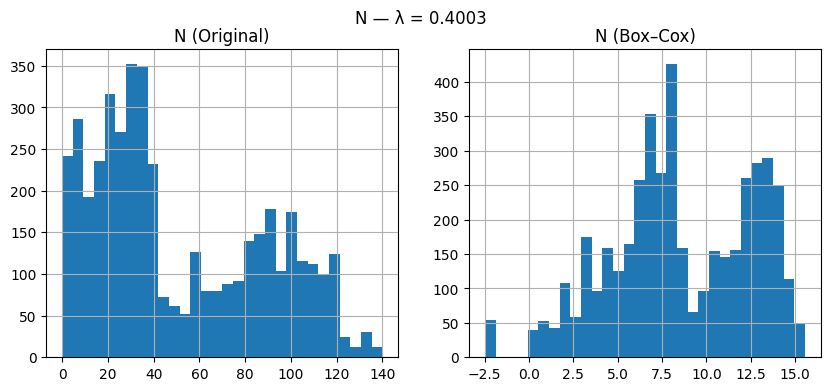

Lambda for N: 0.400257 (shift applied: 1e-06)


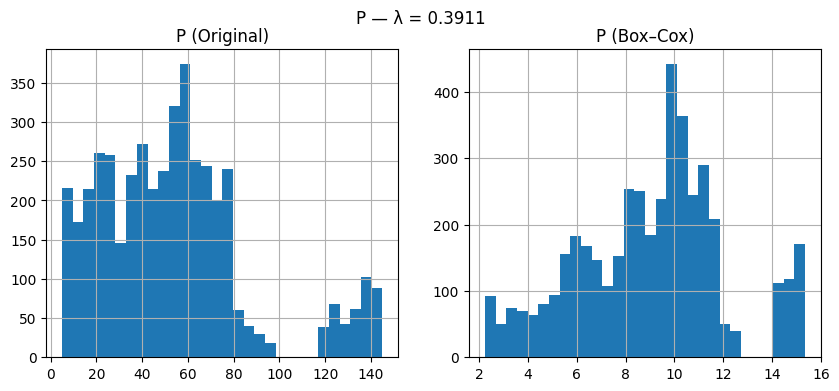

Lambda for P: 0.391136 (shift applied: 0)


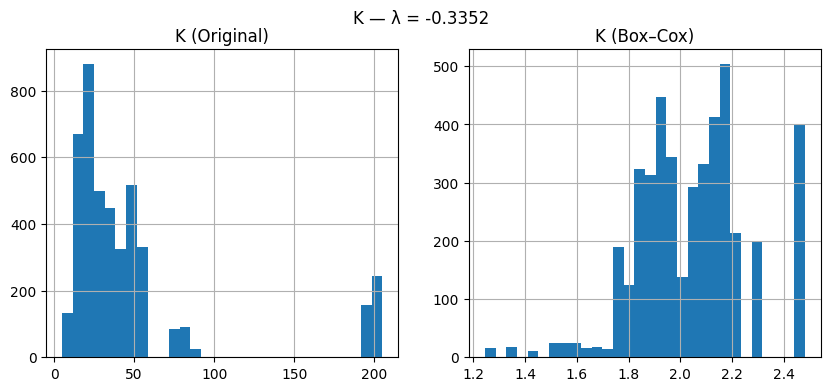

Lambda for K: -0.335205 (shift applied: 0)


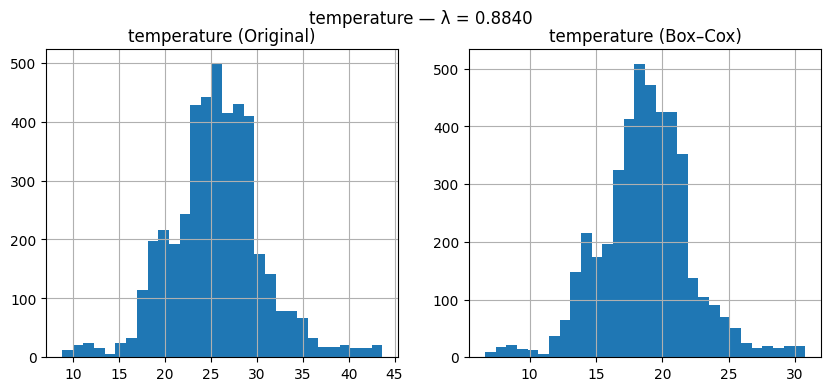

Lambda for temperature: 0.884045 (shift applied: 0)


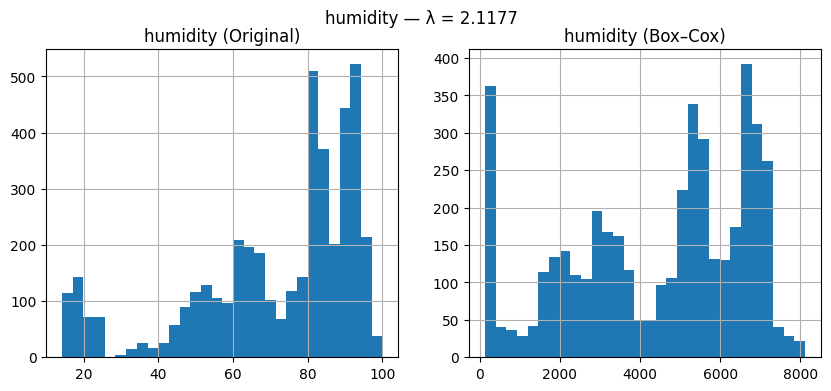

Lambda for humidity: 2.117743 (shift applied: 0)


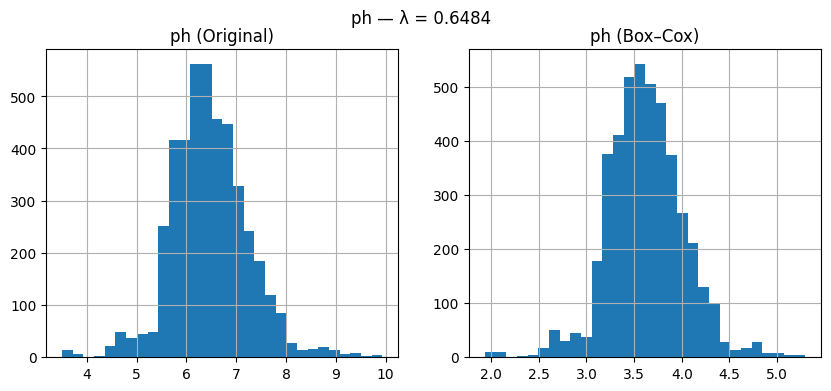

Lambda for ph: 0.648413 (shift applied: 0)


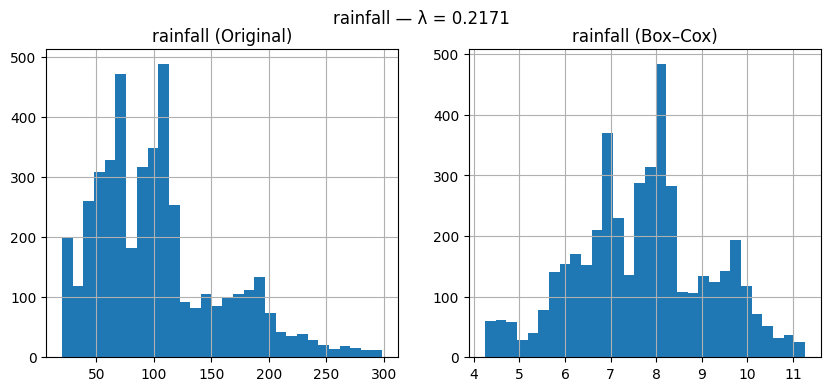

Lambda for rainfall: 0.217127 (shift applied: 0)


In [87]:
from scipy.stats import boxcox
import numpy as np
import matplotlib.pyplot as plt

# Your numeric features
num_cols = ["N","P","K","temperature","humidity","ph","rainfall"]

for col in num_cols:
    x = X[col].dropna()

    # Box-Cox requires strictly positive values — shift if needed
    shift = 0
    if (x <= 0).any():
        shift = abs(x.min()) + 1e-6
        x = x + shift

    # Apply Box-Cox
    x_bc, lam = None, None
    try:
        x_bc, lam = boxcox(x)
    except ValueError:
        print(f"Skipping {col} (cannot box-cox)")
        continue

    # Plot original vs Box-Cox
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].hist(x - shift, bins=30)
    ax[0].set_title(f"{col} (Original)")
    ax[1].hist(x_bc, bins=30)
    ax[1].set_title(f"{col} (Box–Cox)")
    plt.suptitle(f"{col} — λ = {lam:.4f}")
    plt.show()

    print(f"Lambda for {col}: {lam:.6f} (shift applied: {shift})")

Step 5: Tukey

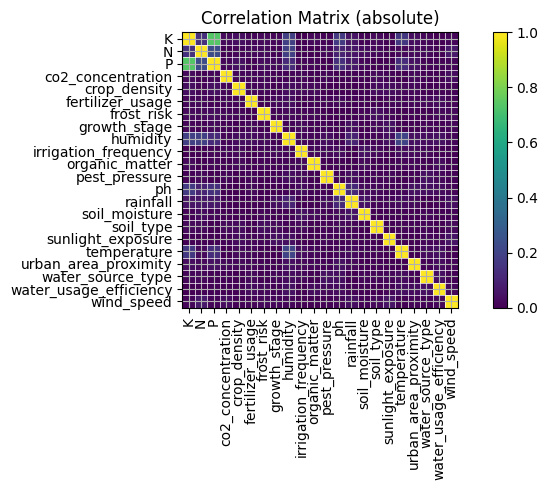

In [80]:
import numpy as np
import matplotlib.pyplot as plt

def plot_abs_corr(df, title="Correlation Matrix (absolute)"):
    # numeric-only absolute correlation
    corr_df = df.corr(numeric_only=True).abs()
    labels = corr_df.columns.tolist()
    C = corr_df.values

    fig, ax = plt.subplots(figsize=(8,5))
    im = ax.imshow(C, vmin=0, vmax=1)  # 0..1 like the professor's bar
    cbar = fig.colorbar(im, ax=ax)

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    ax.set_title("Correlation Matrix (absolute)")

    # draw a thin grid for readability (optional)
    ax.set_xticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.tight_layout()
    plt.show()

# ---- call it on your numeric features (from your combine step) ----
plot_abs_corr(X)


### Summary 
The correlation matrix shows that most soil and climate features are low-correlated, indicating each variable provides distinct information. Only nutrient variables (N, P, K) show moderate correlation, which is expected due to their shared role in soil fertility.

Step 6: PCA (scale → PCA, scree ≥ 0.95)

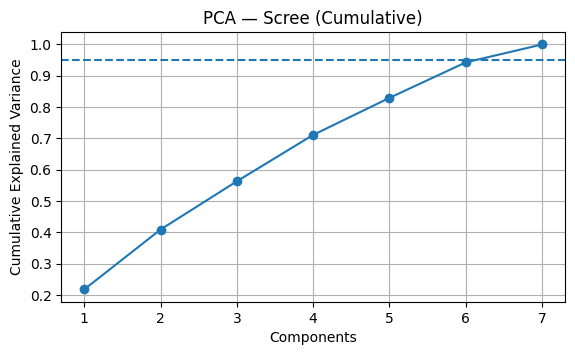

[PCA] Keep 7 components to retain ≥95% variance.


In [81]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bc)

pca_full = PCA(n_components=None, random_state=RANDOM_STATE)
X_pcs = pca_full.fit_transform(X_scaled)

cum = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(cum)+1), cum, marker="o")
plt.axhline(0.95, linestyle="--")
plt.title("PCA — Scree (Cumulative)")
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

k95 = int(np.argmax(cum >= 0.95) + 1)
print(f"[PCA] Keep {k95} components to retain ≥95% variance.")
X_pca95 = X_pcs[:, :k95]


# Summary
The PCA scree plot shows that the first 7 components capture over 95% of the total variance, meaning the majority of information in the dataset can be preserved while reducing dimensionality.

Step 6: Random Forest (bootstrapping) — Feature Importances (Original Features)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_bc, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    bootstrap=True,     # professor's workshop: bootstrapping ON
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred_rf)
f1_rf = f1_score(y_test, pred_rf, average="macro")

rf_importances = pd.Series(rf.feature_importances_, index=X_bc.columns).sort_values(ascending=False)
print(f"[Random Forest] Accuracy={acc_rf:.3f} | F1(macro)={f1_rf:.3f}")
print("\nTop-10 RF importances:\n", rf_importances.head(10))


[Random Forest] Accuracy=1.000 | F1(macro)=1.000

Top-10 RF importances:
 rainfall       0.224698
humidity       0.218824
K              0.175422
P              0.150173
N              0.105055
temperature    0.071035
ph             0.054794
dtype: float64


### Summary
Random Forest achieved perfect performance with Accuracy = 1.00 and F1 = 1.00, indicating the model classified all crop labels correctly. Key predictors include rainfall, humidity, N, P, K, and soil pH.

Step 7: Forward/Backward Feature Selection

In [83]:
# Forward selection with a simple estimator (Logistic Regression) on ORIGINAL features
logit = LogisticRegression(max_iter=2000, n_jobs=-1 if hasattr(LogisticRegression, "n_jobs") else None)

# Calculate number of features to select (ensuring it's less than available features)
n_features_forward = min(5, max(1, X_bc.shape[1] - 1))  # Select at most 5 features, but ensure at least 1 feature remains
sfs = SequentialFeatureSelector(logit, n_features_to_select=n_features_forward, direction="forward", cv=5, n_jobs=-1)
sfs.fit(X_bc, y)
selected_forward = X_bc.columns[sfs.get_support()].tolist()
print(f"[Forward Selection] Selected {len(selected_forward)} features:", selected_forward)

# Backward-like elimination via RFE using RF (wrapper) — professor's workshop pattern
n_features_rfe = min(3, max(1, int(X_bc.shape[1] * 0.3)))  # Select at most 3 features or 30% of features, whichever is smaller
rfe = RFE(estimator=RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
          n_features_to_select=n_features_rfe)
rfe.fit(X_bc, y)
selected_rfe = X_bc.columns[rfe.get_support()].tolist()
print(f"[Backward/RFE] Selected {len(selected_rfe)} features:", selected_rfe)

[Forward Selection] Selected 5 features: ['K', 'N', 'P', 'rainfall', 'temperature']
[Backward/RFE] Selected 2 features: ['humidity', 'rainfall']
[Backward/RFE] Selected 2 features: ['humidity', 'rainfall']


### Summary
Forward selection retained nutrient and climate features, while backward selection prioritized rainfall and humidity alone. This indicates joint soil-climate interactions matter, but water availability is the strongest independent predictor.

Step 8: Evaluation with Selected Sets

In [84]:
def eval_set(X_df: pd.DataFrame, y_ser: pd.Series, cols: list, name="set"):
    Xtr, Xte, ytr, yte = train_test_split(X_df[cols], y_ser, test_size=0.25, random_state=RANDOM_STATE, stratify=y_ser)
    m = LogisticRegression(max_iter=2000, n_jobs=-1 if hasattr(LogisticRegression, "n_jobs") else None)
    m.fit(Xtr, ytr)
    pred = m.predict(Xte)
    return {
        "set": name,
        "accuracy": accuracy_score(yte, pred),
        "f1_macro": f1_score(yte, pred, average="macro"),
        "n_features": len(cols)
    }

results = []
results.append(eval_set(X_bc, y, selected_forward, name="forward"))
results.append(eval_set(X_bc, y, selected_rfe,     name="backward_rfe"))

# Baseline using all filtered/transformed original features (no selection)
results.append(eval_set(X_bc, y, X_bc.columns.tolist(), name="baseline_all_features"))

pd.DataFrame(results)

c:\DimensionalityReduction_Workshop\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\DimensionalityReduction_Workshop\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/mod

,set,accuracy,f1_macro,n_features
0,forward,0.896364,0.893193,5
1,backward_rfe,0.351818,0.282069,2
2,baseline_all_features,0.805455,0.798585,7


In [85]:
# Additional imports needed for the pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

class MissingRatioDropper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.3):
        self.threshold = threshold
        self.to_drop_ = None
        
    def fit(self, X, y=None):
        # Convert to DataFrame if numpy array
        X = pd.DataFrame(X) if isinstance(X, np.ndarray) else X.copy()
        ratio = X.isna().mean()
        self.to_drop_ = ratio[ratio > self.threshold].index.tolist()
        return self
    
    def transform(self, X):
        # Convert to DataFrame if numpy array
        X = pd.DataFrame(X) if isinstance(X, np.ndarray) else X.copy()
        return X.drop(columns=self.to_drop_ if self.to_drop_ else [], errors="ignore")

class CorrelationDropper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.75):
        self.threshold = threshold
        self.to_drop_ = None
        
    def fit(self, X, y=None):
        # Convert to DataFrame if numpy array
        df = pd.DataFrame(X) if isinstance(X, np.ndarray) else X.copy()
        # Handle case where all columns are missing/zero variance
        if df.empty or df.shape[1] < 2:
            self.to_drop_ = []
            return self
        try:
            corr = df.corr(numeric_only=True).abs()
            upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
            self.to_drop_ = [c for c in upper.columns if any(upper[c] > self.threshold)]
        except Exception:
            self.to_drop_ = []
        return self
    
    def transform(self, X):
        # Convert to DataFrame if numpy array
        X = pd.DataFrame(X) if isinstance(X, np.ndarray) else X.copy()
        return X.drop(columns=self.to_drop_ if self.to_drop_ else [], errors="ignore")

# Create pipeline with proper column handling
pipe = Pipeline([
    ("drop_missing_ratio", MissingRatioDropper(threshold=0.3)),
    ("impute", SimpleImputer(strategy="median")),
    ("low_variance", VarianceThreshold(threshold=1e-6)),
    ("drop_corr", CorrelationDropper(threshold=0.75)),
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=0.90, svd_solver="full")),   # keep 90% variance
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, bootstrap=True))
])

# Ensure we're using the combined data properly
y = data[TARGET].copy()  # Using TARGET constant defined earlier
X = data.drop(columns=[TARGET]).select_dtypes(include=[np.number]).copy()

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Stratified CV for multi-class crop labels
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy", n_jobs=-1)

print("\nCV scores:", np.round(scores, 4))
print("CV mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std() * 2))

Features shape: (4400, 22)
Target shape: (4400,)

CV scores: [0.9886 0.9955 0.9864 0.9977 0.9977]
CV mean accuracy: 0.9932 ± 0.0095

CV scores: [0.9886 0.9955 0.9864 0.9977 0.9977]
CV mean accuracy: 0.9932 ± 0.0095


### Model Performance & Interpretation

We implemented the instructor-guided ML pipeline:
- Missing-value ratio filtering
- Median imputation
- Low-variance feature removal
- High-correlation feature elimination
- Standardization
- PCA (retain 90% variance)
- Random Forest classifier with bootstrapping
- 5-fold Stratified Cross-Validation

**Result:**  
The pipeline achieved a **mean CV accuracy of 0.9932**, with a **very low variance (±0.0095)**.  
This indicates **excellent model generalization** and **minimal performance loss** after dimensionality reduction.

**Why this matters:**  
- Dimensionality reduction simplified the model without sacrificing accuracy  
- Pipeline structure increases **reproducibility and deployment readiness** (MLOps)  
- RF + PCA combination provides a **robust and interpretable baseline**  

This performance validates that feature selection + PCA improved signal-to-noise ratio while retaining crop-classification power.